In [2]:
!pip3 install tensorflow
!pip3 install tensorflow-datasets
!pip3 install matplotlib

  Using cached tensorflow-2.11.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (588.3 MB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached tensorflow_io_gcs_filesystem-0.28.0-cp39-cp39-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (2.4 MB)
  Using cached keras-2.11.0-py2.py3-none-any.whl (1.7 MB)
  Using cached termcolor-2.1.1-py3-none-any.whl (6.2 kB)
  Using cached tensorflow_estimator-2.11.0-py2.py3-none-any.whl (439 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached flatbuffers-22.12.6-py2.py3-none-any.whl (26 kB)
  Using cached libclang-14.0.6-py2.py3-none-manylinux2010_x86_64.whl (14.1 MB)
  Using cached tensorboard-2.11.0-py3-none-any.whl (6.0 MB)
  Using cached absl_py-1.3.0-py3-none-any.whl (124 kB)
  Using cached tensorboard_plugin_wit-1.8.1-py3-none-any.whl (781 kB)
  Using cached tensorboard_data_serve

  Using cached importlib_resources-5.10.1-py3-none-any.whl (34 kB)
  Created wheel for promise: filename=promise-2.3-py3-none-any.whl size=21503 sha256=4396ac5b0576cbde60dbceba123a7adff4a13420bb4f8b9d9f0fdcad01de09bd
  Stored in directory: /home/annalena/.cache/pip/wheels/e1/e8/83/ddea66100678d139b14bc87692ece57c6a2a937956d2532608
Successfully built promise


In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
from datetime import datetime

%load_ext tensorboard

2022-12-09 19:55:38.314619: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-09 19:55:38.421829: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-09 19:55:38.424636: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-09 19:55:38.424649: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

# Creating Dataset
The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

FeaturesDict({
    'id': Text(shape=(), dtype=object),
    'image': Image(shape=(32, 32, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
})


In [8]:
#1. get mnist from tensorflow datasets
cifar, info = tfds.load("cifar10", split=["train","test"], as_supervised=True, with_info=True)
train_ds_orig = cifar[0]
val_ds_orig = cifar[1]

#2. Preproces the data using the map method or scanabebenroth
def preprocess(data, batch_size):
    data = data.map(lambda x, t: (tf.cast(x, float), t))
    #data = data.map(lambda x, t: (tf.reshape(x, (-1,)), t))
    data = data.map(lambda x, t: ((x/128.)-1., t))
    data = data.map(lambda x, t: (x, tf.one_hot(t, depth=10)))
    data = data.cache()
    data = data.shuffle(1000)
    data = data.batch(batch_size)
    data = data.prefetch(20)
    return data

train_ds = preprocess(train_ds_orig, batch_size=32)
val_ds = preprocess(val_ds_orig, batch_size=32)

(32, 32, 32, 3) (32, 10)


2022-12-09 20:32:36.075836: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-12-09 20:32:36.076324: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-12-09 20:32:36.116428: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. I

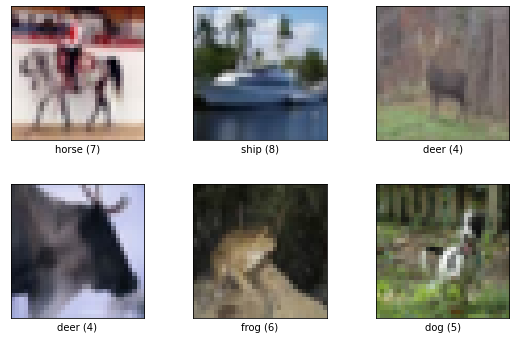

In [9]:
for img1, label in train_ds.take(1):
    print(img1.shape, label.shape)
fig = tfds.show_examples(train_ds_orig.take(6), info)

# Create a model
basic CNN model like VGG

In [25]:
class ConvModel(tf.keras.Model):

  #1 Constructor
  def __init__(self, L2_reg=0.001, dropout_rate=0, batch_norm=False):
    super(ConvModel, self).__init__()
    #inherit functionality from parent class
    # init optimisation/regularisation
    kernel_regularizer=tf.keras.regularizers.L2(L2_reg) if L2_reg else None
    self.dropout_rate = dropout_rate
    if self.dropout_rate:
        self.dropout_layer = tf.keras.layers.Dropout(dropout_rate)

    #optimizer, loss function and metrics
    self.metrics_list = [
                        tf.keras.metrics.CategoricalCrossentropy(name="loss"),
                        tf.keras.metrics.CategoricalAccuracy(name="acc"),
                        tf.keras.metrics.Mean(name="total_frobenius_norm")
                       ]
    self.optimizer = tf.keras.optimizers.Adam()
    self.loss = tf.keras.losses.CategoricalCrossentropy()

    # layers to be used
    self.convlayer1 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')
    self.convlayer2 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')
    self.pooling = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)

    self.convlayer3 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')
    self.convlayer4 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')
    self.global_pool = tf.keras.layers.GlobalAvgPool2D()

    self.out = tf.keras.layers.Dense(10, activation='softmax')


  #2. call method (forward computation)
  def call(self, img, training=False):
    x = self.convlayer1(img)
    x = self.convlayer2(x)
    x = self.pooling(x)
    x = self.convlayer3(x)
    x = self.convlayer4(x)
    x = self.global_pool(x)

    return self.out(x)

  #3. metrics property
  @property
  def metrics(self):
    # return a list with all metrics in the model
    return self.metrics_list


  #4 reset all metrics object
  def reset_metrics(self):
    for metric in self.metrics:
      metric.reset_states()

  def compute_frobenius(self):
    frobenius_norm = tf.zeros((1,))
    for var in self.trainable_variables:
        frobenius_norm += tf.norm(var, ord="euclidean")
    return frobenius_norm

  #5 training step method
  @tf.function
  def train_step(self, data):
    # update the state of the metrics according to loss
    # return a dictionary with metrics name as keys an metric results
    img, label = data
    with tf.GradientTape() as tape:
      output = self(img, training=True)
      loss = self.loss(label, output)

    gradients = tape.gradient(loss, self.trainable_variables)

    self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

    #update the state of the metrics according to loss
    self.metrics[0].update_state(label, output)
    self.metrics[1].update_state(label, output)
    self.metrics[2].update_state(self.compute_frobenius())

    # return a dictionary with metric names as keys and metric results as values
    return {m.name : m.result() for m in self.metrics}
    

  #6. test step method
  @tf.function
  def test_step(self, data):
    img, label = data
    output = self(img, training=False)
    loss = self.loss(label, output)
    self.metrics[0].update_state(label, output)
    self.metrics[1].update_state(label, output)
    self.metrics[2].update_state(self.compute_frobenius())

    return {"val_"+m.name : m.result() for m in self.metrics}



# Write a training loop functions


In [17]:
import tqdm
def training_loop(model, train_ds, val_ds, epochs, save_path):
    train_history = {"loss":[], "acc":[], "total_frobenius_norm":[]}
    val_history = {"val_loss":[], "val_acc":[], "val_total_frobenius_norm":[]}
    #1. iterate over epochs
    for e in range(epochs):
        #2. train steps on all batchs in the training data
        for data in tqdm.tqdm(train_ds):
            metrics = model.train_step(data)
        # 3. log and print data metrics
        for key, value in metrics.items():
            train_history[key].append(value)
        # print the metrics
        print([f"{key}: {value.numpy()}" for (key, value) in metrics.items()])
        #4 reset the metrics
        model.reset_metrics()
        #5. evaluate on validation data
        for data in val_ds:
            metrics = model.test_step(data)
    
        #6. log validation metrics
        for key, value in metrics.items():
            val_history[key].append(value)

        # print the metrics
        print([f"{key}: {value.numpy()}" for (key, value) in metrics.items()])
    
        #7. reset metric objects
        model.reset_metrics()

    #8 save model weights
    model.save_weights(save_path)
    return train_history, val_history

# Use the training loop function to train the model

In [26]:
#1. instantiate model
model = ConvModel()
model(tf.keras.Input((32,32,3)))
model.summary()
epochs=15

#2. choose a path to save the weights
save_path = "trained_model"

train_history, val_history = training_loop(model, train_ds, val_ds, epochs, save_path)

Model: "conv_model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          multiple                  896       
                                                                 
 conv2d_21 (Conv2D)          multiple                  9248      
                                                                 
 max_pooling2d_5 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 conv2d_22 (Conv2D)          multiple                  18496     
                                                                 
 conv2d_23 (Conv2D)          multiple                  36928     
                                                                 
 global_average_pooling2d_5   multiple                 0         
 (GlobalAveragePooling2D)                             

100%|███████████████████████████████████████| 1563/1563 [01:56<00:00, 13.37it/s]


['loss: 1.6542948484420776', 'acc: 0.38245999813079834', 'total_frobenius_norm: 34.92998504638672']
['val_loss: 1.4050909280776978', 'val_acc: 0.48420000076293945', 'val_total_frobenius_norm: 41.92970657348633']


100%|███████████████████████████████████████| 1563/1563 [02:14<00:00, 11.60it/s]


['loss: 1.2953805923461914', 'acc: 0.5356199741363525', 'total_frobenius_norm: 47.51811599731445']
['val_loss: 1.1869169473648071', 'val_acc: 0.5784000158309937', 'val_total_frobenius_norm: 52.280517578125']


100%|███████████████████████████████████████| 1563/1563 [02:18<00:00, 11.29it/s]


['loss: 1.112401008605957', 'acc: 0.6066799759864807', 'total_frobenius_norm: 56.073909759521484']
['val_loss: 1.0245444774627686', 'val_acc: 0.6359000205993652', 'val_total_frobenius_norm: 59.57892990112305']


100%|███████████████████████████████████████| 1563/1563 [02:59<00:00,  8.71it/s]


['loss: 1.015168309211731', 'acc: 0.6420599818229675', 'total_frobenius_norm: 62.801918029785156']
['val_loss: 0.9696708917617798', 'val_acc: 0.6557000279426575', 'val_total_frobenius_norm: 65.79959106445312']


100%|███████████████████████████████████████| 1563/1563 [02:43<00:00,  9.56it/s]


['loss: 0.9452599883079529', 'acc: 0.6674000024795532', 'total_frobenius_norm: 68.69475555419922']
['val_loss: 0.9221190214157104', 'val_acc: 0.670799970626831', 'val_total_frobenius_norm: 71.44390106201172']


100%|███████████████████████████████████████| 1563/1563 [02:09<00:00, 12.03it/s]


['loss: 0.8871155381202698', 'acc: 0.6895800232887268', 'total_frobenius_norm: 74.03482055664062']
['val_loss: 0.8903620839118958', 'val_acc: 0.6804999709129333', 'val_total_frobenius_norm: 76.6137924194336']


100%|███████████████████████████████████████| 1563/1563 [00:32<00:00, 48.15it/s]


['loss: 0.8397907018661499', 'acc: 0.7053800225257874', 'total_frobenius_norm: 78.9723129272461']
['val_loss: 0.8530420064926147', 'val_acc: 0.6973999738693237', 'val_total_frobenius_norm: 81.32029724121094']


100%|███████████████████████████████████████| 1563/1563 [00:33<00:00, 46.79it/s]


['loss: 0.7961949110031128', 'acc: 0.7207199931144714', 'total_frobenius_norm: 83.54051208496094']
['val_loss: 0.869239091873169', 'val_acc: 0.6959999799728394', 'val_total_frobenius_norm: 85.73826599121094']


100%|███████████████████████████████████████| 1563/1563 [00:34<00:00, 45.93it/s]


['loss: 0.7608770132064819', 'acc: 0.7335600256919861', 'total_frobenius_norm: 87.8068618774414']
['val_loss: 0.7758840918540955', 'val_acc: 0.7287999987602234', 'val_total_frobenius_norm: 89.84766387939453']


100%|███████████████████████████████████████| 1563/1563 [00:33<00:00, 46.37it/s]


['loss: 0.7269625663757324', 'acc: 0.7448199987411499', 'total_frobenius_norm: 91.84593200683594']
['val_loss: 0.7695227265357971', 'val_acc: 0.7342000007629395', 'val_total_frobenius_norm: 93.78321838378906']


100%|███████████████████████████████████████| 1563/1563 [00:34<00:00, 45.66it/s]


['loss: 0.6942588090896606', 'acc: 0.7561200261116028', 'total_frobenius_norm: 95.61385345458984']
['val_loss: 0.7752311825752258', 'val_acc: 0.7289999723434448', 'val_total_frobenius_norm: 97.43018341064453']


100%|███████████████████████████████████████| 1563/1563 [00:34<00:00, 45.64it/s]


['loss: 0.6673157215118408', 'acc: 0.7674400210380554', 'total_frobenius_norm: 99.23355865478516']
['val_loss: 0.7451558709144592', 'val_acc: 0.7429999709129333', 'val_total_frobenius_norm: 100.9764404296875']


100%|███████████████████████████████████████| 1563/1563 [00:34<00:00, 45.63it/s]


['loss: 0.6421985030174255', 'acc: 0.7770199775695801', 'total_frobenius_norm: 102.739013671875']
['val_loss: 0.723550021648407', 'val_acc: 0.7526999711990356', 'val_total_frobenius_norm: 104.42727661132812']


100%|███████████████████████████████████████| 1563/1563 [00:34<00:00, 45.85it/s]


['loss: 0.6131067872047424', 'acc: 0.785860002040863', 'total_frobenius_norm: 106.05142211914062']
['val_loss: 0.6876856684684753', 'val_acc: 0.7648000121116638', 'val_total_frobenius_norm: 107.62113189697266']


100%|███████████████████████████████████████| 1563/1563 [00:33<00:00, 46.37it/s]


['loss: 0.596546471118927', 'acc: 0.7911400198936462', 'total_frobenius_norm: 109.2381820678711']
['val_loss: 0.693745493888855', 'val_acc: 0.7631000280380249', 'val_total_frobenius_norm: 110.79080963134766']


Task 2.2.: Use different methods to test if model overfits

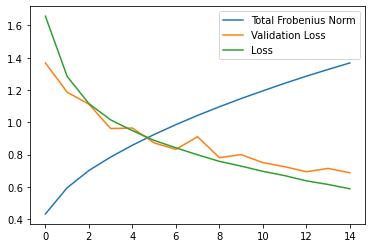

In [23]:
import numpy as np
import matplotlib.pyplot as plt
# added frobenius metrics to model
plt.plot(train_history["total_frobenius_norm"]/np.max(train_history["total_frobenius_norm"]) * np.max(val_history["val_loss"]))
plt.plot(val_history["val_loss"])
plt.plot(train_history["loss"])
plt.legend(labels=["Total Frobenius Norm", "Validation Loss", "Loss"])
plt.savefig("convnet_vgg_loss.svg")
plt.show()

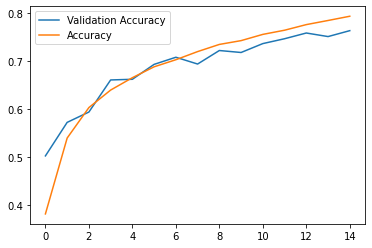

In [24]:
plt.plot(val_history["val_acc"])
plt.plot(train_history["acc"])
plt.legend(labels=["Validation Accuracy", "Accuracy"])
plt.savefig("convnet_vgg_accuracy.svg")
plt.show()